### Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from neural_final_proj.core_models import CustomCNN, ResNetSmall 
from neural_final_proj.project_utils import prepare_data_loaders, evaluate_model
from neural_final_proj.adversarial_logic import generate_adversarial_set, train_robust_model
from neural_final_proj.pruning import count_sparse_weights, prune_and_evaluate, measure_inference_latency

class ConfigC:
    """
    Configuration for Problem C: Adversarial Training (PGD-AT).
    Uses attack parameters determined in Problem B.
    """
    data_root = "data/Sports"
    image_size = 64
    batch_size = 64
    num_classes = 10 
    num_epochs = 20
    device = torch.device("cpu")
    

    out_dir = "problem_C_outputs" 
    ckpt_dir = "problem_A_outputs" 
    model_A_ckpt = "CustomCNN-original.pt"
    model_to_robustify = "CustomCNN"
    
    # --- Adversarial Training (AT) Settings ---
    # These parameters must match the strongest attack from Problem B
    PGD_EPS = 8 / 255.0
    PGD_ALPHA = 2 / 255.0
    PGD_STEPS = 20

cfg = ConfigC()

In [3]:
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir('..')
current_folder_name = os.path.basename(os.getcwd())

# Create output directory
os.makedirs(cfg.out_dir, exist_ok=True)

WIDTH = 20
print(f"{'Current directory':<{WIDTH}}: {current_folder_name}")
print(f"{'Model to Robustify':<{WIDTH}}: {cfg.model_to_robustify}")
print(f"{'Device':<{WIDTH}}: {cfg.device}")
print(f"{'PGD Epsilon (L-inf)':<{WIDTH}}: {cfg.PGD_EPS:.4f}")
print(f"{'Output Location':<{WIDTH}}: {cfg.out_dir}\n")

Current directory   : EE4745_Final_Proj
Model to Robustify  : CustomCNN
Device              : cpu
PGD Epsilon (L-inf) : 0.0314
Output Location     : problem_C_outputs



### Adversarial Training

In [4]:
# Load Data Loaders (using helper from project_utils)
train_loader, val_loader, class_names, _ = prepare_data_loaders(
    cfg.data_root, cfg.image_size, cfg.batch_size
)

# Select Model to Train
model_class = CustomCNN
model_name = "CustomCNN_Robust"
model_robust = model_class(num_classes=cfg.num_classes).to(cfg.device)

# Start Adversarial Training
results_robust_cnn = train_robust_model(model_robust, model_name, train_loader, val_loader, cfg)

print(f"\nCustomCNN Training Complete.")
WIDTH = 26
print(f"{'Final Validation Accuracy':<{WIDTH}}: {results_robust_cnn['final_val_accuracy']:.2f}%")
print(f"{'Total Time Taken':<{WIDTH}}: {results_robust_cnn['total_training_time']:.2f}s")


--- Starting ADVERSARIAL TRAINING for CustomCNN_Robust ---
Epoch 1/20 | Train Acc: 22.16% | Val Acc: 30.00% | Time: 21.59s
Epoch 2/20 | Train Acc: 33.46% | Val Acc: 40.00% | Time: 21.72s
Epoch 3/20 | Train Acc: 41.43% | Val Acc: 62.00% | Time: 21.96s
Epoch 4/20 | Train Acc: 46.64% | Val Acc: 46.00% | Time: 22.24s
Epoch 5/20 | Train Acc: 50.28% | Val Acc: 56.00% | Time: 23.78s
Epoch 6/20 | Train Acc: 53.36% | Val Acc: 50.00% | Time: 22.72s
Epoch 7/20 | Train Acc: 54.61% | Val Acc: 52.00% | Time: 22.05s
Epoch 8/20 | Train Acc: 56.31% | Val Acc: 62.00% | Time: 21.19s
Epoch 9/20 | Train Acc: 60.39% | Val Acc: 66.00% | Time: 21.44s
Epoch 10/20 | Train Acc: 64.28% | Val Acc: 62.00% | Time: 21.57s
Epoch 11/20 | Train Acc: 66.60% | Val Acc: 60.00% | Time: 21.42s
Epoch 12/20 | Train Acc: 68.36% | Val Acc: 64.00% | Time: 22.74s
Epoch 13/20 | Train Acc: 70.18% | Val Acc: 66.00% | Time: 22.71s
Epoch 14/20 | Train Acc: 75.71% | Val Acc: 64.00% | Time: 22.85s
Epoch 15/20 | Train Acc: 77.84% | Val A

In [5]:
# Load Original Model for Comparison
model_original = model_class(num_classes=cfg.num_classes).to(cfg.device)
original_ckpt_path = os.path.join(cfg.ckpt_dir, cfg.model_A_ckpt)
print(f"Loading original model from      : {original_ckpt_path}")
model_original.load_state_dict(torch.load(original_ckpt_path, map_location=cfg.device))

# Reload Best Robust Model Checkpoint
robust_ckpt_path = os.path.join(cfg.out_dir, f"{results_robust_cnn['model_name']}-robust.pt")
print(f"Loading best robust weights from : {robust_ckpt_path}")
model_robust.load_state_dict(torch.load(robust_ckpt_path, map_location=cfg.device))

Loading original model from      : problem_A_outputs\CustomCNN-original.pt
Loading best robust weights from : problem_C_outputs\CustomCNN_Robust-robust.pt


<All keys matched successfully>

### Adversarial Training Evaluation

In [6]:
#  Clean Accuracy (Utility Test)
_, clean_acc_robust, _, _ = evaluate_model(model_robust, val_loader, nn.CrossEntropyLoss(), cfg.device)
_, clean_acc_original, _, _ = evaluate_model(model_original, val_loader, nn.CrossEntropyLoss(), cfg.device)

# Generate PGD attacks on the validation set using the ROBUST model
adv_robust_set = generate_adversarial_set(
    model_robust, val_loader, 'pgd', cfg.PGD_EPS, targeted=False, target_class_idx=-1,
    num_samples=len(val_loader.dataset), alpha=cfg.PGD_ALPHA, steps=cfg.PGD_STEPS
)

# Robust Accuracy = 100 * (1 - Attack Success Rate)
robust_acc_robust = (len(adv_robust_set) - sum(int(e["success"]) for e in adv_robust_set)) / len(adv_robust_set) * 100

# Generate PGD attacks on the validation set using the ORIGINAL model
adv_original_set = generate_adversarial_set(
    model_original, val_loader, 'pgd', cfg.PGD_EPS, targeted=False, target_class_idx=-1,
    num_samples=len(val_loader.dataset), alpha=cfg.PGD_ALPHA, steps=cfg.PGD_STEPS
)
robust_acc_original = (len(adv_original_set) - sum(int(e["success"]) for e in adv_original_set)) / len(adv_original_set) * 100

### Final Reporting for Robust Model

In [7]:
WIDTH_MODEL = 20
WIDTH_ACCURACY = 25
WIDTH_ROBUST_ACC = 25

print(f"\nAdversarial Training Parameters: PGD Epsilon={cfg.PGD_EPS:.4f}, Steps={cfg.PGD_STEPS}")
print("\n"+5*" "+"Adversarial Results\n"+(WIDTH_MODEL + WIDTH_ACCURACY + WIDTH_ROBUST_ACC)*"-")

print(
    f"{'Model':<{WIDTH_MODEL}}" +
    f"{'Clean Accuracy (%)':<{WIDTH_ACCURACY}}" +
    f"{'Robust Accuracy (PGD %)':<{WIDTH_ROBUST_ACC}}"
)

results_data = [
    {"Model": "Original Model", "Clean Acc": clean_acc_original, "Robust Acc": robust_acc_original},
    {"Model": "Robust Model", "Clean Acc": clean_acc_robust, "Robust Acc": robust_acc_robust}
]

for r in results_data:
    print(
        f"{r['Model']:<{WIDTH_MODEL}}" +
        f"{r['Clean Acc']:<{WIDTH_ACCURACY}.2f}" + # Using .2f for two decimal places
        f"{r['Robust Acc']:<{WIDTH_ROBUST_ACC}.2f}"
    )


Adversarial Training Parameters: PGD Epsilon=0.0314, Steps=20

     Adversarial Results
----------------------------------------------------------------------
Model               Clean Accuracy (%)       Robust Accuracy (PGD %)  
Original Model      80.00                    65.00                    
Robust Model        68.00                    85.29                    


### Pruning Execution and Efficiency Measurement

In [16]:
model_class_prune = CustomCNN 
model_a_ckpt = os.path.join(cfg.ckpt_dir, cfg.model_A_ckpt) # Path to the unpruned CustomCNN
train_loader, val_loader, class_names, _ = prepare_data_loaders(
    cfg.data_root, cfg.image_size, cfg.batch_size
)

sparsity_levels = [0.2, 0.5, 0.8]
pruning_results = []

# --- 1. Establish Baseline (Unpruned) ---
model_baseline = model_class_prune(num_classes=cfg.num_classes).to(cfg.device)
model_baseline.load_state_dict(torch.load(model_a_ckpt, map_location=cfg.device))

# Baseline Evaluation (using evaluate_model imported from project_utils)
_, baseline_acc, _, _ = evaluate_model(model_baseline, val_loader, nn.CrossEntropyLoss(), cfg.device)
baseline_latency, _ = measure_inference_latency(model_baseline, cfg, batch_size=1)
total_w_baseline, _, _ = count_sparse_weights(model_baseline)
baseline_size_mb = os.path.getsize(model_a_ckpt) / (1024 * 1024)

# Add baseline to results (Sparsity = 0%)
pruning_results.append({
    'Sparsity (%)': 0.0,
    'Accuracy (Pre-Finetune)': baseline_acc,
    'Accuracy (Post-Finetune)': baseline_acc,
    'Param Count': total_w_baseline,
    'Model Size (MB)': baseline_size_mb,
    'Latency (ms)': baseline_latency,
    'Model Checkpoint': model_a_ckpt
})

print(f"--- Baseline Established (Sparsity 0%): {baseline_acc:.2f}% Acc, {baseline_latency:.4f} ms Latency ---")

# --- 2. Prune, Fine-Tune, and Evaluate for each Sparsity Level ---
for s_level in sparsity_levels:
    print(f"\n--- Pruning Model to {s_level*100:.0f}% Sparsity ---")
    
    # This calls the helper function from pruning.py
    res = prune_and_evaluate(
        model_class=model_class_prune,
        model_ckpt_path=model_a_ckpt,
        sparsity_level=s_level,
        cfg=cfg,
        train_loader=train_loader,
        val_loader=val_loader,
        evaluate_model_func=evaluate_model, 
        finetune_epochs=5
    )
    
    # Measure Latency on the Post-Finetune model
    model_post_finetune = model_class_prune(num_classes=cfg.num_classes).to(cfg.device)
    model_post_finetune.load_state_dict(torch.load(res['model_ckpt_path'], map_location=cfg.device))
    
    latency, _ = measure_inference_latency(model_post_finetune, cfg, batch_size=1)

    pruning_results.append({
        'Sparsity (%)': res['sparsity_actual']*100, 
        'Accuracy (Pre-Finetune)': res['acc_pre_finetune'],
        'Accuracy (Post-Finetune)': res['acc_post_finetune'],
        'Param Count': res['param_count'], 
        'Model Size (MB)': res['model_size_mb'],
        'Latency (ms)': latency,
        'Model Checkpoint': res['model_ckpt_path']
    })
    WIDTH = 28
    print(f"{'Actual Sparsity':<{WIDTH}}: {res['sparsity_actual']*100:.2f}%")
    print(f"{'Accuracy Pre/Post Finetune':<{WIDTH}}: {res['acc_pre_finetune']:.2f}% / {res['acc_post_finetune']:.2f}%")
    print(f"{'Inference Latency':<{WIDTH}}: {latency:.4f} ms (Batch 1)")
    
# Finalize DataFrame for Summary Table and Plots
df_pruning = pd.DataFrame(pruning_results)
df_pruning['Sparsity (%)'] = df_pruning['Sparsity (%)'].round(2)
df_pruning['Accuracy (Pre-Finetune)'] = df_pruning['Accuracy (Pre-Finetune)'].round(2)
df_pruning['Accuracy (Post-Finetune)'] = df_pruning['Accuracy (Post-Finetune)'].round(2)
df_pruning['Model Size (MB)'] = df_pruning['Model Size (MB)'].round(2)
df_pruning['Latency (ms)'] = df_pruning['Latency (ms)'].round(4)

--- Baseline Established (Sparsity 0%): 80.00% Acc, 0.8725 ms Latency ---

--- Pruning Model to 20% Sparsity ---
Actual Sparsity             : 20.00%
Accuracy Pre/Post Finetune  : 80.00% / 80.00%
Inference Latency           : 0.8244 ms (Batch 1)

--- Pruning Model to 50% Sparsity ---
Actual Sparsity             : 50.00%
Accuracy Pre/Post Finetune  : 80.00% / 80.00%
Inference Latency           : 0.7465 ms (Batch 1)

--- Pruning Model to 80% Sparsity ---
Actual Sparsity             : 80.00%
Accuracy Pre/Post Finetune  : 82.00% / 82.00%
Inference Latency           : 0.7817 ms (Batch 1)


### Robustness Check on Pruned Models

In [17]:
# 1. Generate PGD Untargeted Attacks on Original Model (Fixed Set)
model_original = CustomCNN(num_classes=cfg.num_classes).to(cfg.device)
model_original.load_state_dict(torch.load(model_a_ckpt, map_location=cfg.device))

print("Generating 10 fixed PGD Untargeted examples on the Original Model...")
pgd_untargeted_examples = generate_adversarial_set(
    model_original, val_loader, 'pgd', cfg.PGD_EPS, targeted=False, target_class_idx=-1,
    num_samples=10, alpha=cfg.PGD_ALPHA, steps=cfg.PGD_STEPS
)
# Robust Accuracy = 100 * (1 - Attack Success Rate)
robust_acc_baseline = (len(pgd_untargeted_examples) - sum(int(e["success"]) for e in pgd_untargeted_examples)) / len(pgd_untargeted_examples) * 100

robustness_data = []
robustness_data.append({
    'Sparsity (%)': 0.0,
    'Robust Acc (PGD Untargeted)': robust_acc_baseline,
})

# 2. Test Robustness of Pruned Models
for index, row in df_pruning.iterrows():
    if row['Sparsity (%)'] > 0: 
        print(f"Testing {row['Sparsity (%)']:.0f}% Pruned Model...")
        
        # Load the POST-FINETUNE pruned model
        model_pruned = CustomCNN(num_classes=cfg.num_classes).to(cfg.device)
        model_pruned.load_state_dict(torch.load(row['Model Checkpoint'], map_location=cfg.device))
        
        # Evaluate the FIXED adversarial set on the pruned model
        robust_success_count = 0
        total_examples = len(pgd_untargeted_examples)
        
        for ex in pgd_untargeted_examples:
            xa = ex["x_adv"].unsqueeze(0).to(cfg.device)
            y_true = ex["y_true"]
            with torch.no_grad():
                logits = model_pruned(xa)
                pred = logits.argmax(dim=1).item()
            
            # Untargeted attack success is when pred != y_true
            if pred != y_true:
                robust_success_count += 1

        # Robust Accuracy = 100 * (1 - Attack Success Rate)
        robust_acc_pruned = 100 * (1 - (robust_success_count / total_examples))
        
        robustness_data.append({
            'Sparsity (%)': row['Sparsity (%)'],
            'Robust Acc (PGD Untargeted)': robust_acc_pruned,
        })

# 3. Final Robustness Reporting Table
df_robustness = pd.DataFrame(robustness_data)

print("\n\n--- Robustness Comparison Table ---")
print("Metric: Robust Accuracy (100 * (1 - ASR)) against PGD Untargeted Attack")
print(df_robustness.to_markdown(index=False))

Generating 10 fixed PGD Untargeted examples on the Original Model...
Testing 20% Pruned Model...
Testing 50% Pruned Model...
Testing 80% Pruned Model...


--- Robustness Comparison Table ---
Metric: Robust Accuracy (100 * (1 - ASR)) against PGD Untargeted Attack
|   Sparsity (%) |   Robust Acc (PGD Untargeted) |
|---------------:|------------------------------:|
|              0 |                            50 |
|             20 |                            40 |
|             50 |                            30 |
|             80 |                            30 |


### Plotting Pruning Results

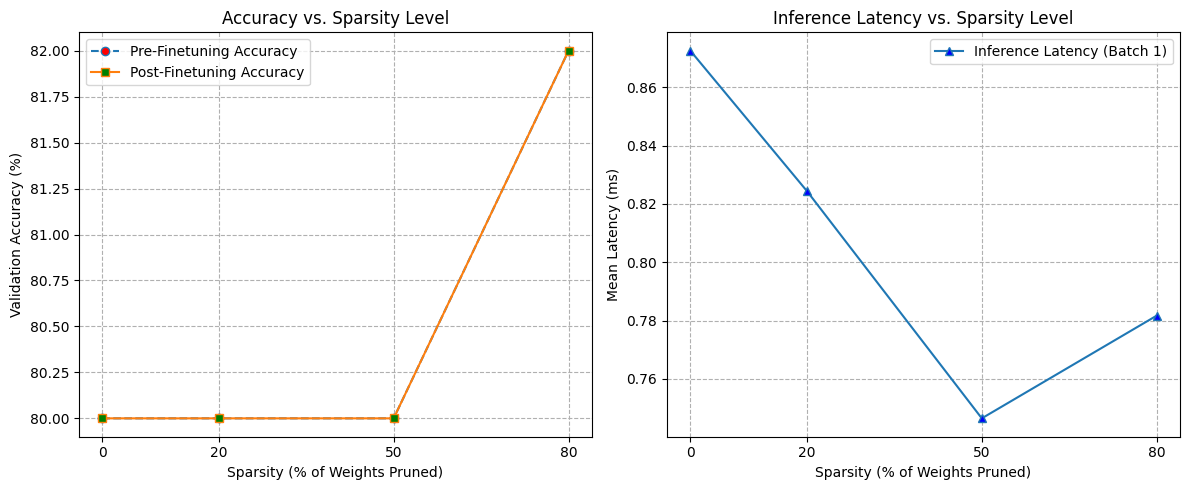

In [18]:
# 1. Accuracy vs. Sparsity Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sparsity_points = df_pruning['Sparsity (%)']
acc_pre = df_pruning['Accuracy (Pre-Finetune)']
acc_post = df_pruning['Accuracy (Post-Finetune)']

plt.plot(sparsity_points, acc_pre, 'o--', label='Pre-Finetuning Accuracy', markerfacecolor='red')
plt.plot(sparsity_points, acc_post, 's-', label='Post-Finetuning Accuracy', markerfacecolor='green')

plt.title('Accuracy vs. Sparsity Level')
plt.xlabel('Sparsity (% of Weights Pruned)')
plt.ylabel('Validation Accuracy (%)')
plt.grid(True, linestyle='--')
plt.legend()
plt.xticks(sparsity_points)


# 2. Latency vs. Sparsity Plot
plt.subplot(1, 2, 2)
latency = df_pruning['Latency (ms)']

plt.plot(sparsity_points, latency, '^-', label='Inference Latency (Batch 1)', markerfacecolor='blue')

plt.title('Inference Latency vs. Sparsity Level')
plt.xlabel('Sparsity (% of Weights Pruned)')
plt.ylabel('Mean Latency (ms)')
plt.grid(True, linestyle='--')
plt.legend()
plt.xticks(sparsity_points)

plt.tight_layout()
plt.show()